# OpenAi CartPole
[Documentation](https://gymnasium.farama.org/environments/classic_control/cart_pole/)  
This environment is part of the Classic Control environments which contains general information about the environment.

## Description
This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson in “Neuronlike Adaptive Elements That Can Solve Difficult Learning Control Problem”. A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.

## imports

In [9]:
import os
import time
import math
import gymnasium as gym
import numpy as np
from numpy import inf
import random
import imageio
from IPython.display import clear_output
from IPython import display
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from PIL import Image
%matplotlib inline

## Global variables

In [2]:
EPISODES = 25000
SHOW_EVERY = 250
RANDOM_SEED = random.randint(1, 5000)
# RANDOM_SEED = 3847 # comment for a random seed
RANDOM_SEED

1179

## Get env informations

In [3]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
env.reset()

print(env.observation_space.high)
print(env.observation_space.low)
print(env.state.shape[0])
print(env.action_space.n)


[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
4
2


## Set-up the Agent

In [4]:
class Agent():
    """
    This class implements the Q-Learning algorithm on the CartPole-v1 OpenAI environment
    """
    def __init__(self, bin_size: int = 30, seed: int = None):
        """
        Agent class initializer.

        Args:
        - bin_size (int): number of discrete bins per feature to be used in the state space discretization
        - seed (int): random seed used for initializing the environment and the numpy random generator
        """
        self.env = gym.make("CartPole-v1", render_mode="rgb_array")
        self.seed = seed
        if self.seed:
            self.env.action_space.seed(self.seed)
            np.random.seed(self.seed)
            
        # initialize environment and Q-Table
        self.reset()
        self.state_space = self.env.state.shape[0] # number of states (Position, Velocity, Angle, Angular Velocity): 4
        self.action_space = self.env.action_space.n # number of possible actions (0, 1): 2
        self.bin_size = bin_size
        self.q_table, self.discrete_os_win_size = self.Qtable()
        
        # Epsilon
        self.epsilon = 0.5
    
    def reset(self):
        """
        Reset the environment and returns its initial state.

        Returns:
        - initial_state (numpy.ndarray): initial state of the environment
        """
        if self.seed:
            return self.env.reset(seed=self.seed)
        else:
            return self.env.reset()

    def __get_last(self, l):
        """
        Private function that returns the last element of a list.

        Args:
        - l (list): input list

        Returns:
        - last element of the input list
        """
        return None if len(l) <= 0 else l[-1]
    
    def Qtable(self):
        """
        Initializes the Q-Table and the state space discretization windows.

        Returns:
        - q_table (numpy.ndarray): Q-Table of dimensions (discrete_state_space x action_space)
        - discrete_os_win_size (numpy.ndarray): discretization windows for each feature of the state space
        """
        high = env.observation_space.high
        low = env.observation_space.low
        
        high[high > 1e30] = 4 # for infinit number we will take 4 as min and max range
        low[low < -1e30] = -4 # for infinit number we will take 4 as min and max range

        discrete_os_size = [self.bin_size] * self.state_space
        discrete_os_win_size = (high - low) / discrete_os_size
        
        q_table = np.random.uniform(low=-2, high=2, size=(discrete_os_size + [self.action_space]))
        return q_table, discrete_os_win_size
    
    def get_discrete(self, state):
        """
        Discretize the continuous state space into a discrete state space.

        Args:
        - state (numpy.ndarray): continuous state space

        Returns:
        - tuple: tuple representing the discretized state space
        """
        low = env.observation_space.low
        low[low < -1e30] = -4 # for infinit number we will take 4 as min and max range
        
        discrete_state = (state - low) / self.discrete_os_win_size
        return tuple(discrete_state.astype(np.int64))
    
    def policy(self, state: tuple):
        """
        Choose an action based on the epsilon-greedy policy.

        Args:
            state (tuple): The current state.

        Returns:
            int: The selected action.
        """
        return np.argmax(self.q_table[state])
    
    def new_Q_value(self, reward: float, new_state: tuple, gamma = 0.95) -> float:
        """
        Calculate the new Q-value for the current state and action.

        Args:
            reward (float): The immediate reward.
            new_state (tuple): The next state.
            gamma (float, optional): The discount factor. Defaults to 0.95.

        Returns:
            float: The new Q-value.
        """
        # Maximum possible QValue in the next step
        max_future_q = np.max(self.q_table[new_state])
        learned_value = reward + gamma * max_future_q
        return learned_value
    
    def learning_rate(self) -> float:
        """
        Return the learning rate.

        Returns:
            float: The learning rate.
        """
        return 0.1
    
    def update_exploration_rate(self, episode: int) -> float:
        """
        Update the exploration rate based on the episode number.

        Args:
            episode (int): The current episode number.

        Returns:
            float: The new exploration rate.
        """
        start_epsilon_decaying = 1
        end_epsilon_decaying = EPISODES // 2
        epsilon_decay_value = self.epsilon / (end_epsilon_decaying - start_epsilon_decaying)
        if end_epsilon_decaying >= episode >= start_epsilon_decaying:
            self.epsilon -= epsilon_decay_value
    
    def fit(self, episodes = 2000):
        """
        Function to train the agent on the Cartpole problem.

        Args:
        - episodes (int): The number of episodes to train the agent. Default is 2000.

        Returns:
        - rewards (list): The list of rewards obtained at each episode.
        - aggr_ep_rewards (dict): A dictionary containing the evolution of the average, minimum and maximum rewards obtained
                                   over the episodes.
        """

        rewards = []
        aggr_ep_rewards = {'ep': [], 'avg': [], 'min': [], 'max': []}
        solved = 0

        for episode in range(episodes):
            print(f"{episode + 1}/{episodes} : sloved=({solved} => {int(solved * 100 / (episode+1))}%) | avg: {self.__get_last(aggr_ep_rewards['avg'])} min: {self.__get_last(aggr_ep_rewards['min'])} max: {self.__get_last(aggr_ep_rewards['max'])}", end="\r")
            # episode initialization 
            discrete_state = self.get_discrete(self.reset()[0])
            score = 0
            step = 0
            done = False

            # learning loop for the current episode
            while not done:
                # action selection
                if np.random.random() > self.epsilon:
                    action = self.policy(discrete_state) # policy action
                else:
                    action = self.env.action_space.sample() # random action

                # increment environment
                observation, reward, terminated, truncated, info = self.env.step(action)
                done = terminated or truncated
                next_state = self.get_discrete(observation)
                score += reward

                # If the simulation did not end - updating Q table
                if not done:
                    # learning from environnement
                    lr = self.learning_rate()
                    learnt_value = self.new_Q_value(reward, next_state)
                    # Current Qvalue for the current state and selected action
                    current_q = self.q_table[discrete_state + (action, )]
                    # QLearning equation to calculate the new Qvalue
                    new_q = (1-lr) * current_q + lr * learnt_value
                    # Updating Qtable
                    self.q_table[discrete_state + (action, )] = new_q
                    
                # if simulation ended and goal position is achived
                elif score >= 475:
                    self.q_table[discrete_state + (action, )] = 0
                    # End of the episode update
                    solved += 1
                
                discrete_state = next_state
                
                step += 1
                
            # Updating epsilon rate
            self.update_exploration_rate(episode)
                
            rewards += [score]
            if not episode % SHOW_EVERY:
                average_reward = sum(rewards[-SHOW_EVERY:])/len(rewards[-SHOW_EVERY:])
                aggr_ep_rewards['ep'] += [episode]
                aggr_ep_rewards['avg'] += [average_reward]
                aggr_ep_rewards['min'] += [min(rewards[-SHOW_EVERY:])]
                aggr_ep_rewards['max'] += [max(rewards[-SHOW_EVERY:])]
                
                
        self.env.close()
        print("\nEnd")
        return rewards, aggr_ep_rewards
    
    def render(self):
        """
        Render the environment and display the simulation as a sequence of plots.

        Returns:
        None
        """
        # Initialize the plot and current state
        img = plt.imshow(self.env.render())
        current_state = self.get_discrete(self.env.reset()[0])
        # Run the simulation for 1000 timesteps
        for t in range(1000):
            # Take an action according to the policy
            action = self.policy(current_state)
            # Perform the action and get the observation, reward, and done signal
            observation, reward, terminated, truncated, info = self.env.step(action)
            done = terminated or truncated

            # Update the plot and display the image
            img.set_data(self.env.render())
            plt.axis('off')
            plt.suptitle(f"Timestep=({t})")
            display.display(plt.gcf())
            clear_output(wait=True)

            # Reset the environment if done signal is True
            if done:
                observation, info = self.reset()
                break
            else:
                current_state = self.get_discrete(observation)

        # Close the environment
        self.env.close()
    
    def __update_plot(self, frame_number, current_state, num_iteration):
        """
        Helper function to update the plot for each timestep in the simulation.

        Args:
        frame_number (int): The current timestep in the simulation.
        current_state (tuple): The current state of the environment.
        num_iteration (int): The number of iterations remaining in the simulation.

        Returns:
        tuple: A tuple containing the new plot image, the updated frame number, the current state, and the number of iterations.
        """
        # Take an action according to the policy
        action = self.policy(current_state)
        # Perform the action and get the observation, reward, and done signal
        observation, reward, terminated, truncated, info = self.env.step(action)
        done = terminated or truncated
        # Get the new state of the environment
        state = self.env.render()

        # converting state to plot in order to stylize it
        fig = Figure()
        canvas = FigureCanvas(fig)
        ax = fig.add_subplot(1,1,1)
        ax.imshow(state)
        ax.axis('off')
        ax.set_title(f"Timestep=({frame_number})")
        canvas.draw()

        # reconverting plot to state
        size = fig.get_size_inches() * fig.dpi
        image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8').reshape(int(size[1]), int(size[0]), 3)

        # Reset the environment if done signal is True
        if done:
            observation, info = self.reset()
            num_iteration -= 1
            time.sleep(0.5)
            frame_number = 0
        else:
            current_state = self.get_discrete(observation)
            frame_number += 1
        return image, frame_number, current_state, num_iteration
    
    def save(self):
        """
        Save the simulation as a GIF.

        Returns:
        None
        """
        # Get the initial state and render it
        current_state = self.get_discrete(self.reset()[0])
        frame = self.env.render()
        # Initialize the number of iterations and frames
        num_iteration = 5
        images = []
        frame_number = 0
        # Run the simulation for num_iteration iterations
        while num_iteration > 0:
            print(f"{(5 - num_iteration)+1}/{5}", end="\r")
            # Update the plot and append the resulting image to images
            frame, frame_number, current_state, num_iteration = self.__update_plot(frame_number, current_state, num_iteration)
            images.append(Image.fromarray(frame))
        # Save the images as a gif
        print("\nSaving..............", end="\r")     
        images[0].save('img/cartpole.gif', format='GIF', save_all=True, append_images=images[1:], duration=50, loop=0)
        print("Saved                   ")

In [5]:
agent_argmax = Agent(bin_size=30)
rewards_argmax, aggr_ep_rewards_argmax = agent_argmax.fit(episodes = EPISODES)

25000/25000 : sloved=(450 => 1%) | avg: 228.436 min: 61.0 max: 500.0
End


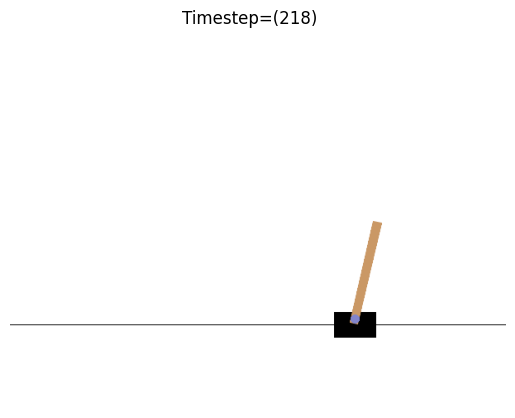

In [6]:
agent_argmax.render()

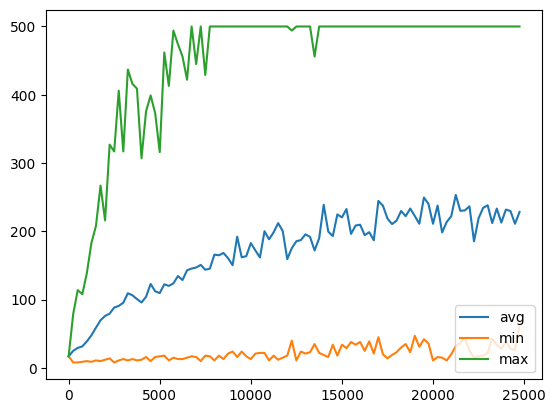

In [7]:
plt.plot(aggr_ep_rewards_argmax['ep'], aggr_ep_rewards_argmax['avg'], label="avg")
plt.plot(aggr_ep_rewards_argmax['ep'], aggr_ep_rewards_argmax['min'], label="min")
plt.plot(aggr_ep_rewards_argmax['ep'], aggr_ep_rewards_argmax['max'], label="max")
plt.legend(loc=4)
plt.show()

In [10]:
agent_argmax.save()

5/5
Saved                   
